## План
Так как, как в базовом варианте, но делаем OHE на `'Округ', 'Район', 'Метро'`

* Дополнительный разведывательный анализ данных:
    * Попарные корреляции интересных категориальных признаков
    * Попарные корреляции интересных количественных признаков

**Отчет 2: Влияние факторов на цену за метр у лотов**

blah_blah

+++
#### Влияние ветки метро
* Для измерения следует обработать данные по станциям, которые встречаются в более чем одной ветке. Например, станция Третьяковская по данным с портала открытых данных города Москвы ([ссылка](https://data.mos.ru/classifier/7704786030-stantsii-moskovskogo-metropolitena) расположена одновременно на трех ветках, одна из которых еще строится. Доступная выгрузка из источника данных не дает такой подробной информации. 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
import statsmodels
PATH_TO_PROCESSED_DATA = '../data/'
PATH_TO_INTER_DATA = '../data/intermediate/'
PATH_TO_IMAGES = '../imgs/'

from collections import defaultdict
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import lightgbm as lgbm
import eli5
import scipy.stats

In [35]:
df = pd.read_csv(PATH_TO_PROCESSED_DATA + 'features_dataset.csv', index_col=[0])
target = pd.read_csv(PATH_TO_PROCESSED_DATA + 'target_column.csv', index_col=[0])
print(df.shape)
print(f'{df.memory_usage().sum() / 1024 / 1024 :.2f} Mb')
assert df.shape[0] == target.shape[0]

(14329, 25)
1.98 Mb


In [77]:
df.nunique()

Округ                                 12
Район                                153
Площадь                             1736
Площадь лог                         1736
Кол-во комнат                          7
Этаж                                  73
Этажей в доме                         73
Первый этаж                            2
Последний этаж                         2
Метро                                272
Расстояние до метро (ед)              58
Расстояние указано пешком              2
Расстояние указано на транспорте       2
Тип дома                               7
Указан раздельный санузел              2
Несколько санузлов                     2
Балкон указан                          2
Окна                                   3
Окна во двор                           2
Ремонт                                 4
Наличие ремонта                        2
Возраст дома                         127
Доля жилой площади                  6122
Доля куханной площади               5253
Площадь кухни   

In [51]:
df.groupby('Округ').size().sort_values(ascending=False)

Округ
ЗАО                     1952
ЦАО                     1778
НАО (Новомосковский)    1673
ЮВАО                    1589
ЮАО                     1413
САО                     1288
ЮЗАО                    1228
СВАО                    1196
СЗАО                     926
ВАО                      832
ТАО (Троицкий)           239
ЗелАО                    215
dtype: int64

In [53]:
df.groupby('Район').size().sort_values(ascending=False)

Район
р-н Некрасовка             535
р-н Пресненский            535
р-н Раменки                463
Коммунарка поселок         372
Сосенское поселение        339
р-н Хамовники              307
р-н Хорошево-Мневники      289
р-н Даниловский            269
р-н Южное Бутово           254
р-н Марьино                232
р-н Можайский              219
р-н Хорошевский            216
р-н Обручевский            210
р-н Ростокино              206
р-н Басманный              198
р-н Щукино                 197
р-н Очаково-Матвеевское    197
р-н Тверской               196
Внуковское поселение       195
р-н Бирюлево Восточное     190
dtype: int64

In [50]:
df.groupby('Метро').size().sort_values(ascending=False)

Метро
Некрасовка                   459
Коммунарка                   338
Ольховая                     281
Бунинская аллея              256
Рассказовка                  220
                            ... 
Александровский сад            2
Лефортово                      1
Улица Народного Ополчения      1
Нахабино                       1
Давыдково                      1
Length: 272, dtype: int64

### Предобрабатываем

> Закодируем `категориальные признки`: Округ, Район, Метро, Кол-во комнат

In [5]:
df.head(1)

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
0,ВАО,р-н Гольяново,33.0,3.496508,1,9.0,9.0,False,True,Первомайская,...,False,False,Во двор,True,Без ремонта,False,51.0,0.484848,0.212121,7.0


In [6]:
logging.info(f'Предобрабатываем: {df.columns[df.dtypes == "object"].values.tolist()}.')
label_encoder_dict = defaultdict(LabelEncoder)

# допустим, что это в функции
df['Округ'] = df['Округ'].astype(str)
df['Район'] = df['Район'].astype(str)
df['Кол-во комнат'] = df['Кол-во комнат'].astype(str)
df['Метро'] = df['Метро'].astype(str)
df['Тип дома'] = df['Тип дома'].astype(str)
df['Окна'] = df['Окна'].astype(str)
df['Ремонт'] = df['Ремонт'].astype(str)

# df['Доля жилой площади'] = df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median'))
# pd.get_dummies(df, columns=['Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'])
# df['Площадь'] = np.log(df['Площадь'])

cat_columns_to_dummies = ['Округ', 'Район', 'Метро']
cat_columns = ['Кол-во комнат', 'Тип дома', 'Окна', 'Ремонт'] # df.columns[df.dtypes == 'object']
df[cat_columns] = df[cat_columns].apply(lambda x: label_encoder_dict[x.name].fit_transform(x)).astype('category')
# label_encoder_dict['Округ'].inverse_transform([8])
# df[cat_columns].apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))

logging.info(f'Предобработка: завершение')

INFO:root:Предобрабатываем: ['Округ', 'Район', 'Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'].
INFO:root:Предобработка: завершение


In [7]:
df = pd.concat([df[df.columns[~df.columns.isin(cat_columns_to_dummies)]],
            pd.get_dummies(df[cat_columns_to_dummies])], axis=1)

In [8]:
df.head(3)

,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Расстояние до метро (ед),Расстояние указано пешком,Расстояние указано на транспорте,...,Метро_Шипиловская,Метро_Шоссе Энтузиастов,Метро_Щелковская,Метро_Щербинка,Метро_Щукинская,Метро_Электрозаводская,Метро_Юго-Восточная,Метро_Юго-Западная,Метро_Южная,Метро_Ясенево
0,33.0,3.496508,0,9.0,9.0,False,True,15.0,True,False,...,0,0,0,0,0,0,0,0,0,0
1,32.0,3.465736,0,4.0,9.0,False,False,12.0,True,False,...,0,0,0,0,0,0,0,0,0,0
2,33.0,3.496508,0,9.0,9.0,False,True,15.0,True,False,...,0,0,0,0,0,0,0,0,0,0


### Моделируем

> Зависимость `цены за метр^2` от признаков лотов (независимо от кол-ва комнат)

In [9]:
def metrics_report(y_pred : np.array, y_true : np.array):
    '''
    Вывод метрик качества и графика рассеивания
    :input:
        predicted and background truth targets
    :return: 
        R2 and Mean Absolute Errors metrics values
    '''
    r2 = sklearn.metrics.r2_score(y_pred, y_true)
    mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
    mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
    
    plt.scatter(y=y_pred, x=y_true, alpha=0.25);
    plt.ylabel('predicted log(Цена за метр^2)')
    plt.xlabel('log(Цена за метр^2)')
    plt.title('Диаграмма рассеивания (log(ˆp), log(p))')
    
    logging.info(f'R2 = {r2:.2f}; MAE = {mae:.2f}; MSE = {mse:.2f}')
    return r2, mae, mse

In [10]:
cols_not_to_use = ['Площадь', 'Площадь кухни']
target_col = 'Цена за метр^2'

logging.info(f'Моделируем: {target_col}.')
logging.info(f'Не используем: {cols_not_to_use}.')
logging.info(f'Используем: {list(df.columns[~df.columns.isin(cols_not_to_use)])}.')

INFO:root:Моделируем: Цена за метр^2.
INFO:root:Не используем: ['Площадь', 'Площадь кухни'].
INFO:root:Используем: ['Площадь лог', 'Кол-во комнат', 'Этаж', 'Этажей в доме', 'Первый этаж', 'Последний этаж', 'Расстояние до метро (ед)', 'Расстояние указано пешком', 'Расстояние указано на транспорте', 'Тип дома', 'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан', 'Окна', 'Окна во двор', 'Ремонт', 'Наличие ремонта', 'Возраст дома', 'Доля жилой площади', 'Доля куханной площади', 'Округ_ВАО', 'Округ_ЗАО', 'Округ_ЗелАО', 'Округ_НАО (Новомосковский)', 'Округ_САО', 'Округ_СВАО', 'Округ_СЗАО', 'Округ_ТАО (Троицкий)', 'Округ_ЦАО', 'Округ_ЮАО', 'Округ_ЮВАО', 'Округ_ЮЗАО', 'Район_nan', 'Район_Внуковское поселение', 'Район_Вороновское поселение', 'Район_Воскресенское поселение', 'Район_Десеновское поселение', 'Район_Завода Мосрентген поселок', 'Район_Киевский рп', 'Район_Кленовское поселение', 'Район_Кокошкино дп', 'Район_Коммунарка поселок', 'Район_Краснопахорское поселение', 'Район

Чуть изменим параметры в сравнении с базовой моделью

In [11]:
regressor = lgbm.LGBMRegressor(max_depth=7, n_estimators=500,
                               num_leaves=12, reg_alpha=1.1, reg_beta=0.5,
                               importance_type='split', 
                               random_state=42)

Посмотрим на метрики качества (насколько хорошо наш алгоритм может объяснить имеющиеся данные)

INFO:root:R2 = 0.88; MAE = 0.10; MSE = 0.02


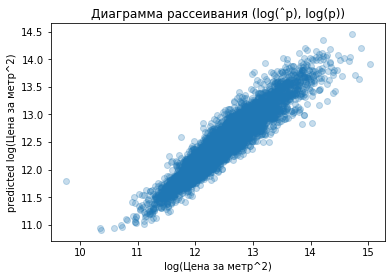

In [12]:
regressor.fit(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
              np.log(target[target_col].values));
metrics_report(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)]),
               np.log(target[target_col].values));

Посмотрим на относительные ошибки

In [13]:
z = np.exp(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)])) - target[target_col].values
z = abs(z) / target[target_col].values
z = pd.DataFrame(z, index=df.iloc[:, ~df.columns.isin(cols_not_to_use)].index, columns=['Ошибка'])
z['Кол-во комнат'] = df['Кол-во комнат']
z['Площадь'] = df['Площадь']

z.groupby('Кол-во комнат')['Ошибка'].quantile(0.8)

Кол-во комнат
0    0.113122
1    0.141177
2    0.162169
3    0.191046
4    0.219087
5    0.309687
6    0.127274
Name: Ошибка, dtype: float64

Посмотрим на значимость признаков

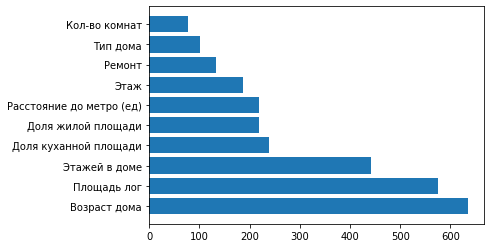

In [14]:
y = df.iloc[:, ~df.columns.isin(cols_not_to_use)].columns[regressor.feature_importances_.argsort()[::-1][:10]]
x = regressor.feature_importances_[regressor.feature_importances_.argsort()[::-1][:10]]
plt.barh(width=x, y=y);

In [15]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.3689,Округ_ЦАО
0.1145,Площадь лог
0.0477,Ремонт
0.0445,Возраст дома
0.0406,Округ_НАО (Новомосковский)
0.0392,Округ_ЗАО
0.0315,Этажей в доме
0.0261,Округ_ТАО (Троицкий)
0.0247,Доля куханной площади
0.0239,Тип дома


In [16]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.1157,Возраст дома
0.1049,Площадь лог
0.0803,Этажей в доме
0.0435,Доля куханной площади
0.0399,Расстояние до метро (ед)
0.0399,Доля жилой площади
0.0342,Этаж
0.0244,Ремонт
0.0184,Тип дома
0.0140,Кол-во комнат


А теперь по нужным категориям

In [17]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re='Округ_*', 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.0124,Округ_ЦАО
0.0087,Округ_ТАО (Троицкий)
0.0084,Округ_НАО (Новомосковский)
0.0084,Округ_ЗАО
0.0053,Округ_ЗелАО
0.0031,Округ_ЮВАО
0.0031,Округ_СЗАО
0.0027,Округ_САО
0.0020,Округ_ЮЗАО
0.0015,Округ_ЮАО


In [18]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re='Метро_*', 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.0038,Метро_Щукинская
0.0036,Метро_Китай-город
0.0036,Метро_Чистые пруды
0.0033,Метро_Пушкинская
0.0029,Метро_Новые Черемушки
0.0029,Метро_Октябрьская
0.0029,Метро_Цветной бульвар
0.0027,Метро_Улица 1905 года
0.0027,Метро_Сокол
0.0026,Метро_Шелепиха


In [19]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re='Район_*', 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.0066,Район_р-н Даниловский
0.0064,Район_р-н Южное Бутово
0.0058,Район_р-н Раменки
0.0058,Район_р-н Некрасовка
0.0056,Район_р-н Солнцево
0.0055,Район_р-н Таганский
0.0055,Район_р-н Хорошевский
0.0055,Район_р-н Гагаринский
0.0053,Район_р-н Южнопортовый
0.0053,Район_р-н Щукино


> Сохраним веса переменных связанных с `Округом, Районом и Метро`

In [20]:
SAVE_TO_FILE = False
with pd.ExcelWriter(PATH_TO_INTER_DATA + 'веса с ohe.xlsx') as writer:
    for feature_name in ['Округ', 'Район', 'Метро']:
        for importance_type in ['gain', 'split']:
            feature_importance_df = eli5.explain_weights_df(estimator=regressor, 
                                                        importance_type=importance_type)
            feature_importance_df = feature_importance_df[feature_importance_df['feature'].str.contains(feature_name)]
            sheet_name = f'Цена за метр ~ {feature_name} {importance_type}'
            if SAVE_TO_FILE:
                feature_importance_df[['weight', 'feature']].to_excel(writer, sheet_name=sheet_name, index=False)
#         break

> Также, можно построить график weight от целевой переменной

In [21]:
# var = feature_name
# df_aux = pd.concat([df[var], target], axis=1)
# df_aux[var] = var + '_' + df_aux[var]
# df_aux = df_aux.groupby(var).median()
# df_aux = df_aux.merge(feature_importance_df, left_on=var, right_on='feature')
# df_aux.plot.scatter(x='Цена за метр^2', y='weight')

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x'], point['y'], str(point['val']))

# ax = df_aux.plot.scatter(x='Цена за метр^2', y='weight')
# label_point(df_aux['Цена за метр^2'], df_aux['weight'], df_aux['feature'], ax)

**Вывод:** мы рассмотрели связь с OHE закодированными переменными локации, значения метрик высоки, но 
1. метрика качества при такой валидации означает лишь то, насколько хорошо алгоритм смог выучить имеющиеся данные и их закономерности (при определенной трактовке задачи этого может быть достаточно, но на всякий случай проведем валидацию на отложенной выборке, а заодно и более регуляризуем наш алгоритм)

### Посмотрим на более регуляризованную модель, на половине выборки и с разбиением по количеству комнат
> * То есть, мы моделируем ситуацию, когда у нас было ~7000 лотов, а потом пришло еще 7000 тысяч, с примерным сохранением количества комнат*, и мы хотим узнать, насколько хорошо наша модель может объяснить цену на них.  
* Проблемой такого подхода может быть недостаточное количество наблюдений по категориям чтобы построить хорошую модель на них


\* Да, мы знаем, что как минимум раз за 10 лет это распределение сдвигается, на основе статьи (Магнус, Пересецкий), но за 10 лет могут происходить куда более серьезные с точки зрения нашей модели изменения, чем лишь изменение количества комнат в лотах. Например, рост цен в несколько раз относительно цен на которых мы моделировали значимости.

In [22]:
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
                                                                              np.log(target[target_col]), 
                                                                              test_size = 0.5, 
                                                                              shuffle = True, 
                                                                              stratify = df['Кол-во комнат'], 
                                                                              random_state = 654)
train_data = lgbm.Dataset(train_x, label=train_y)
valid_data = lgbm.Dataset(valid_x, label=valid_y)

In [23]:
params = {'metric' : 'mse',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 12,
          'max_depth' : 7,
          'n_estimators' : 500,
          #'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 1.1,
          'reg_beta': 0.5,
          'subsample': 0.855,
          'verbose' : 100,
          'learning_rate' : 0.1,
          'num_threads' : 2}

In [24]:
#Train model on selected parameters and number of iterations
regressor_2 = lgbm.train(params,
                 train_data,
                 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 120,
                 verbose_eval = 500
                 )
regressor_2.booster_ = regressor_2

D:\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 120 rounds.
[500]	valid_0's l2: 0.0345665
Did not meet early stopping. Best iteration is:
[499]	valid_0's l2: 0.0345499


Посмотрим на метрики качества (насколько хорошо наш, но чуть более строгий алгоритм, мог бы объяснить 'новые' данные с такой же природой)

INFO:root:R2 = 0.80; MAE = 0.13; MSE = 0.03


(0.7970539145424538, 0.1280817820533646, 0.03454986573579075)

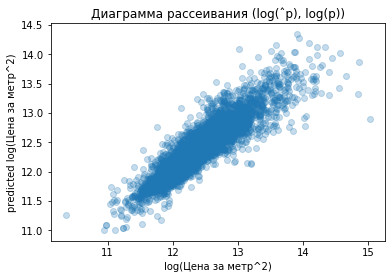

In [25]:
metrics_report(regressor_2.predict(valid_x), valid_y)

Относительные ошибки

In [26]:
z = np.exp(regressor_2.predict(valid_x)) - np.exp(valid_y)
z = abs(z) / np.exp(valid_y)
z = pd.DataFrame(z)
z['Кол-во комнат'] = valid_x['Кол-во комнат']
z['Площадь'] = valid_x['Площадь лог']

z.groupby('Кол-во комнат')['Цена за метр^2'].quantile(0.9)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Кол-во комнат
0    0.188361
1    0.247299
2    0.267192
3    0.313695
4    0.430040
5    0.626384
6    0.215785
Name: Цена за метр^2, dtype: float64

In [27]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.3652,Округ_ЦАО
0.1243,Площадь лог
0.0463,Ремонт
0.0381,Этажей в доме
0.0373,Округ_НАО (Новомосковский)
0.0359,Округ_ЗАО
0.0346,Возраст дома
0.0339,Доля куханной площади
0.0303,Тип дома
0.0275,Район_р-н Раменки


In [28]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.1178,Площадь лог
0.1035,Возраст дома
0.0770,Этажей в доме
0.0696,Доля жилой площади
0.0641,Доля куханной площади
0.0513,Расстояние до метро (ед)
0.0416,Этаж
0.0288,Ремонт
0.0225,Тип дома
0.0183,Кол-во комнат


**Вывод:** значения метрик ожидаемо стали хуже (например, R^2 упал, значение метрики относительной ошибки прогноза выросло), но 
1. модель теперь более регуляризована по признакам и искусственно недостигает точки остановы по критерию отсутствия изменения метрики качества (для этого нужно добавить деревьев, но увеличить риск уменьшения обобщающей спобосности)
2. мы не контроллировали разбиения по другим категориальным признакам, только по числу комнат, это может быть и вероятно есть критично для данных этой структуры (высокое количество районов, высокое количество пропусков в некоторых полях) 
3. самые значимые признаки всё равно остаются неизменными.

> Посмотрим на еще один способ изучить значимость признаков
* SHAP

In [29]:
import shap

Wall time: 0 ns


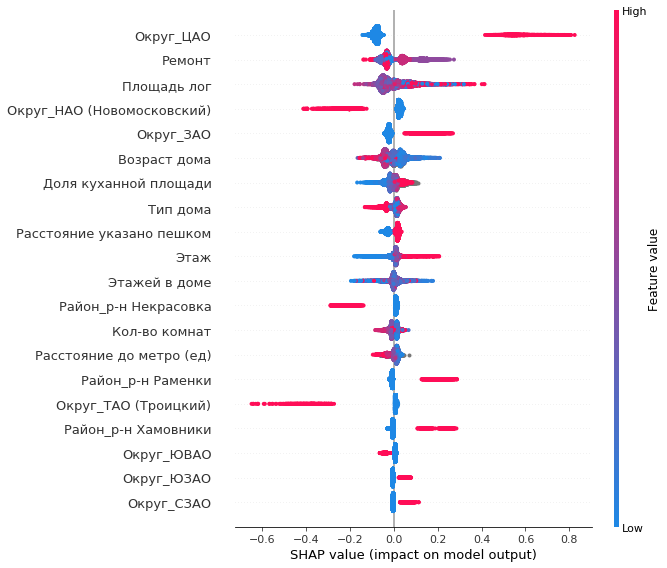

In [30]:
%time
# https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
# https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(df.iloc[:, ~df.columns.isin(cols_not_to_use)])
shap.summary_plot(shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

Только округи

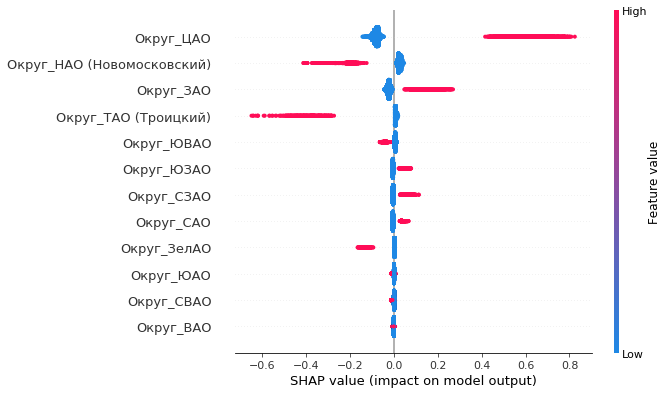

In [31]:
shap.summary_plot(shap_values=shap_values[:, df.columns[~df.columns.isin(cols_not_to_use)].str.contains('Округ_*')], 
                  features=df.iloc[:, df.columns.str.contains('Округ_*')])

Только район

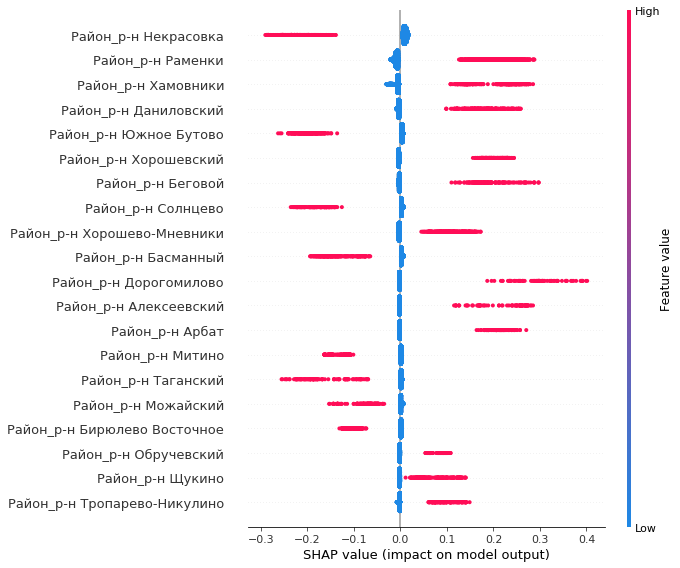

In [32]:
shap.summary_plot(shap_values=shap_values[:, df.columns[~df.columns.isin(cols_not_to_use)].str.contains('Район_*')], 
                  features=df.iloc[:, df.columns.str.contains('Район_*')])

Только метро

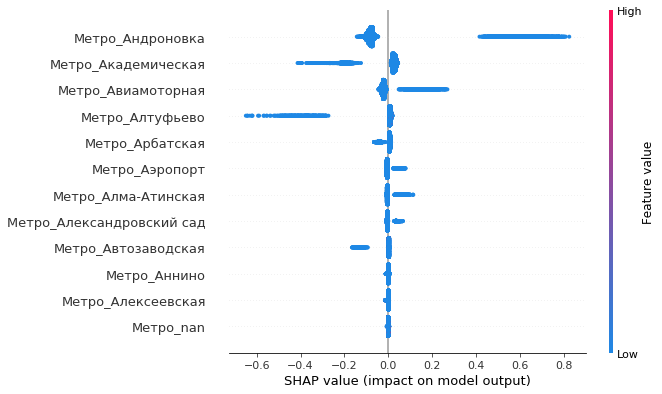

In [33]:
shap.summary_plot(shap_values=shap_values[:, df.columns[~df.columns.isin(cols_not_to_use)].str.contains('Округ_*')], 
                  features=df.iloc[:, df.columns.str.contains('^Метро_*')])